# Importing Libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [3]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [6]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [7]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [9]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [10]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [11]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [12]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [13]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [14]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [15]:
dic={}
for key in profit_and_loss:
    dic[key]=profit_and_loss[key].to_dict()

In [16]:
realized_pnl_time=pd.DataFrame(dic).sort_index().ffill().fillna(0)
realized_pnl_time.index=pd.to_datetime(realized_pnl_time.index).round(freq='d')
realized_pnl_time=realized_pnl_time.groupby(realized_pnl_time.index).sum()

In [17]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT')

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.935036,4107.472863,1.0000,-131.886217,1922.53,1790.643783
OMUSDT,526.319895,1842.865558,0.4487,0.000000,1316.55,1316.550000
BTCUSDT,601.021649,903.272814,0.2199,3.537078,302.25,305.787078
JASMYUSDT,387.458505,518.880098,0.1263,0.000000,131.42,131.420000
SOLUSDT,281.200518,397.263515,0.0967,0.000000,116.06,116.060000
ETHUSDT,250.747339,258.302171,0.0629,0.000000,7.55,7.550000
TRXUSDT,76.868953,130.666544,0.0318,-10.723889,53.80,43.076111
BBUSDT,60.176053,54.969839,0.0134,-39.733101,-5.21,-44.943101
BNBUSDT,1.142121,1.252320,0.0003,-10.606040,0.11,-10.496040
PEPEUSDT,0.000004,0.000005,0.0000,-38.521986,0.00,-38.521986


In [18]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [19]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [20]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [21]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [23]:
position=pd.read_excel('Positions.xlsx',index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [24]:
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx')

quantities_tickers=list(quantities.columns)

In [25]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])

In [26]:
price_pnl.index=pd.to_datetime(price_pnl.index)
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()
for col in quantities:
    
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost.iloc[-1][col])

pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]

C:\Users\niroo\AppData\Local\Temp\ipykernel_265804\1175112299.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]


In [27]:
pnl_history['Total']-pnl_history['Total'].shift(1)

2024-09-23           NaN
2024-09-24     23.503339
2024-09-25     -7.470131
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2025-01-01     25.654174
2025-01-02    118.901567
2025-01-03    101.051243
2025-01-04     47.134486
2025-01-05    -46.879699
Name: Total, Length: 105, dtype: float64

In [28]:
pnl_history['Total']

2024-09-23    -378.365173
2024-09-24    -354.861834
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
                 ...     
2025-01-01    1472.093934
2025-01-02    1590.995501
2025-01-03    1692.046743
2025-01-04    1739.181229
2025-01-05    1692.301530
Name: Total, Length: 105, dtype: float64

In [29]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [30]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [31]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [32]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


C:\Users\niroo\AppData\Local\Temp\ipykernel_265804\974280261.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  binance_data=np.log(1+binance_data.pct_change())


In [33]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [34]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [35]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<Axes: >

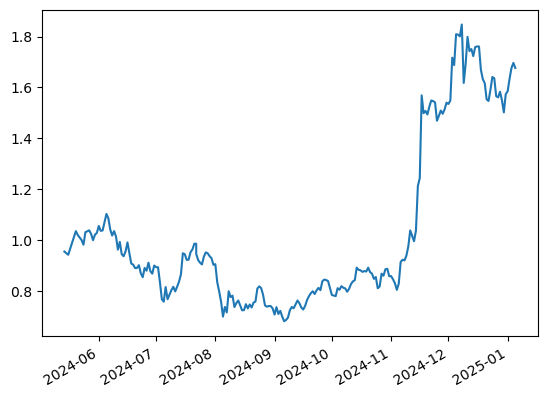

In [36]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [38]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [41]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [42]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [45]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
OMUSDT,0.3927
BNBUSDT,0.2047
SUIUSDT,0.1262
PEPEUSDT,0.1092
XLMUSDT,0.0571
TRXUSDT,0.0494
XRPUSDT,0.0487
AAVEUSDT,0.0090
JASMYUSDT,0.0026
ADAUSDT,0.0004


In [46]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.371705
BTCUSDT,0.300000
SUIUSDT,0.105834
PEPEUSDT,0.072820
BNBUSDT,0.064462
XLMUSDT,0.046948
TRXUSDT,0.038231


### Current results

In [48]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [49]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BTCUSDT,0.463651
OMUSDT,0.360459
TRXUSDT,0.175890


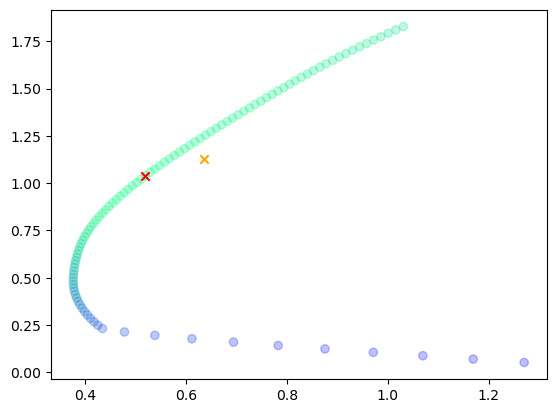

In [50]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

## Real Portfolio vs Optimal

In [52]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1842.865558,0.448662,0.360459,0.088203
BTCUSDT,903.272814,0.219910,0.463651,-0.243741
JASMYUSDT,518.880098,0.126326,0.000000,0.000000
SOLUSDT,397.263515,0.096717,0.000000,0.000000
ETHUSDT,258.302171,0.062886,0.000000,0.000000
TRXUSDT,130.666544,0.031812,0.175890,-0.144078
BBUSDT,54.969839,0.013383,0.000000,0.000000
BNBUSDT,1.252320,0.000305,0.000000,0.000000
PEPEUSDT,0.000005,0.000000,0.000000,0.000000


In [53]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1842.865558,0.448662,0.371705,0.076957
BTCUSDT,903.272814,0.219910,0.300000,-0.080090
JASMYUSDT,518.880098,0.126326,0.000000,0.000000
SOLUSDT,397.263515,0.096717,0.000000,0.000000
ETHUSDT,258.302171,0.062886,0.000000,0.000000
TRXUSDT,130.666544,0.031812,0.038231,-0.006419
BBUSDT,54.969839,0.013383,0.000000,0.000000
BNBUSDT,1.252320,0.000305,0.064462,-0.064157
PEPEUSDT,0.000005,0.000000,0.072820,-0.072820
SUIUSDT,0.000000,0.000000,0.105834,0.000000


# Risk Reward Analysis

In [55]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [56]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<Axes: >

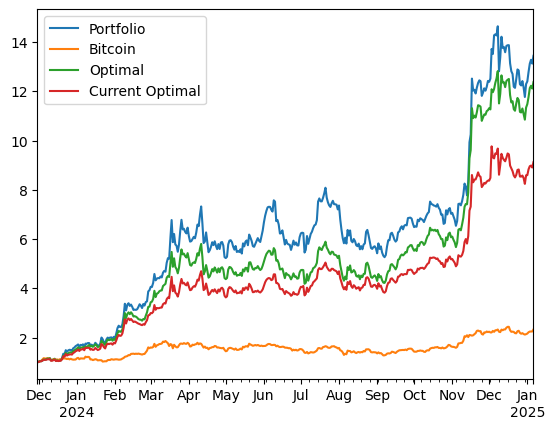

In [57]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [58]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<Axes: >

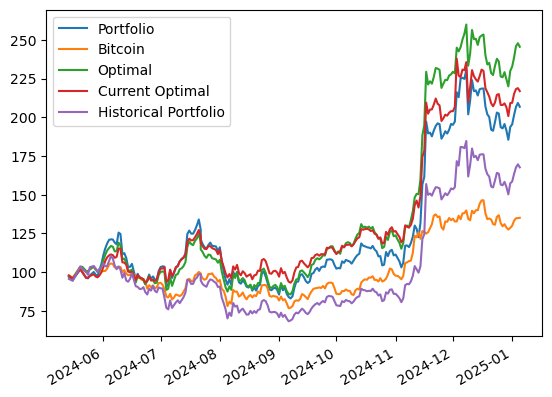

In [59]:
((1+current_perf).cumprod()*100).plot()

In [60]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-12-27,192.857239,129.591304,225.898569,207.938724,156.109214
2024-12-28,195.669527,130.959647,229.177051,209.034880,158.313612
2024-12-29,191.468024,128.795667,224.446049,206.515301,155.021297
2024-12-30,185.490537,127.489058,219.998512,200.758457,150.230127
2024-12-31,193.774908,128.561620,229.956616,209.231834,157.391828
2025-01-01,195.435996,129.949667,232.756440,209.371512,158.517587
2025-01-02,201.469452,133.196261,238.634154,215.164120,163.431516
2025-01-03,206.760667,134.819802,245.938591,218.258899,167.633746
2025-01-04,209.283751,134.883397,247.863940,218.859734,169.632126
2025-01-05,206.830389,135.079783,245.582617,216.949836,167.667349


## Volatilities

In [62]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.623743
 dtype: float64,
 0.6244935871370451)

In [63]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.635649
 dtype: float64,
 0.6356485096271502)

In [64]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.710657
Bitcoin            0.430572
Optimal            0.624494
Current Optimal    0.580538
dtype: float64

In [65]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.4496599089569936

## Risk Contribution

In [67]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.109657,0.064462,0.008133,0.023884,0.002408,0.021476
BTCUSDT,0.399987,0.300000,0.032696,0.136371,0.042784,0.093587
OMUSDT,19.081937,0.371705,0.908672,0.658095,0.553879,0.104216
PEPEUSDT,0.358276,0.072820,0.020136,0.073123,0.021288,0.051835
SUIUSDT,0.355700,0.105834,0.021558,0.076845,0.026222,0.050623
TRXUSDT,0.034562,0.038231,0.003400,0.011228,0.001735,0.009493
XLMUSDT,0.068755,0.046948,0.005404,0.020453,0.003541,0.016912


In [68]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.919125,0.360459,0.566368,0.634804,0.510412,0.124392
BTCUSDT,0.232156,0.463651,0.307977,0.228362,0.131516,0.096847
TRXUSDT,0.107999,0.175890,0.125655,0.136833,0.082846,0.053987


In [69]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,1.147444,0.45,0.682762,0.656794,0.532819,0.123975
BTCUSDT,0.110157,0.22,0.141112,0.088839,0.019833,0.069006
JASMYUSDT,0.038586,0.13,0.072055,0.133041,0.049330,0.083711
SOLUSDT,0.023936,0.10,0.052972,0.070629,0.010237,0.060391
ETHUSDT,0.006154,0.06,0.028275,0.028284,0.002595,0.025689
TRXUSDT,0.018420,0.03,0.020695,0.011985,0.001614,0.010371
BBUSDT,-0.005018,0.01,0.002129,0.010429,0.000399,0.010030


# Value At Risk

## Historical

### Optimal Weights

In [73]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.050958686139710864, -0.07317703118517321)

### Current Weights

In [75]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.04817170476980165, -0.07323698439329612)

In [76]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [77]:
var=historical_var.iloc[row]
var

OMUSDT      -0.017510
BTCUSDT     -0.011273
JASMYUSDT   -0.010558
SOLUSDT     -0.007623
ETHUSDT      0.000944
TRXUSDT     -0.001870
BBUSDT      -0.000124
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.048014
Name: 2024-11-25 00:00:00, dtype: float64

In [78]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.040066
BTCUSDT     -0.007979
JASMYUSDT   -0.011908
SOLUSDT     -0.006871
ETHUSDT     -0.002569
TRXUSDT     -0.001043
BBUSDT      -0.000861
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.071297
dtype: float64

## Parametric

### Optimal Weights

In [81]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.06470755191002069, -0.08293719090138586)

### Current Weights

In [83]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.0658633807943329, -0.08441864396208637)

## Multivariate

### Optimal Weights

In [86]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05782324041113376, -0.07401917474428645)

### Current Weights

In [88]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06293595392612811, -0.08009296265439622)

In [89]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.042853
BTCUSDT     -0.004446
JASMYUSDT   -0.007455
SOLUSDT     -0.004211
ETHUSDT     -0.001110
TRXUSDT     -0.000574
BBUSDT      -0.000665
Portfolio   -0.061315
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [93]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05776359311650698, -0.07368939857574823)

### Current Weights

In [95]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.059649961120644385, -0.0760580382120687)

In [96]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.039921
BTCUSDT     -0.005490
JASMYUSDT   -0.008225
SOLUSDT     -0.004771
ETHUSDT     -0.001827
TRXUSDT     -0.000557
BBUSDT      -0.000663
Portfolio   -0.061455
dtype: float64

## Student Copula

### Optimal Weights

In [99]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05741995306760295, -0.0747319221272078)

### Current Weights

In [101]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06297562128069883, -0.08113303659269153)

In [102]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.043868
BTCUSDT     -0.005418
JASMYUSDT   -0.005961
SOLUSDT     -0.004136
ETHUSDT     -0.001743
TRXUSDT     -0.000747
BBUSDT      -0.000641
Portfolio   -0.062515
dtype: float64

## Gumbel Copula

### Optimal Weights

In [105]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.10668498762756935, -0.1529886317235117)

### Current Weights

In [107]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.10714109388365266, -0.15110781049151625)

In [108]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.102234
BTCUSDT     -0.002163
JASMYUSDT   -0.003214
SOLUSDT     -0.000547
ETHUSDT     -0.000039
TRXUSDT     -0.000326
BBUSDT       0.000359
Portfolio   -0.108165
dtype: float64

## Monte Carlo

### Optimal

In [111]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [112]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06702211364263627, -0.08335360524501027)

### Current Weights

In [114]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06785649578794214, -0.0839290328225198)

In [115]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.044409
BTCUSDT     -0.005451
JASMYUSDT   -0.009205
SOLUSDT     -0.004907
ETHUSDT     -0.001931
TRXUSDT     -0.000727
BBUSDT      -0.000688
Portfolio   -0.067317
dtype: float64

## VaR Violation

In [117]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.054794,-0.092502,-0.075222,-0.024945
2024-01-15,-0.054794,-0.092575,-0.075944,0.023794
2024-01-16,-0.054794,-0.091829,-0.074407,0.038648
2024-01-17,-0.054794,-0.093593,-0.077352,-0.026344
2024-01-18,-0.054794,-0.096598,-0.079994,-0.040028
...,...,...,...,...
2025-01-02,-0.087949,-0.073716,-0.078425,0.025253
2025-01-03,-0.087949,-0.074741,-0.076399,0.030609
2025-01-04,-0.087949,-0.074673,-0.074420,0.007829
2025-01-05,-0.087949,-0.074287,-0.074896,-0.009204


In [118]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.035086,-0.084754,-0.079391,-0.017360
2024-05-29,-0.035086,-0.082109,-0.075799,-0.008743
2024-05-30,-0.035086,-0.072021,-0.069730,0.038147
2024-05-31,-0.035086,-0.073103,-0.064571,0.039093
2024-06-01,-0.035086,-0.076659,-0.067595,0.053278
...,...,...,...,...
2025-01-02,-0.043194,-0.064482,-0.067361,0.030872
2025-01-03,-0.043194,-0.064694,-0.063583,0.026263
2025-01-04,-0.043194,-0.064588,-0.060165,0.012203
2025-01-05,-0.041846,-0.059016,-0.053382,-0.011723


<Axes: >

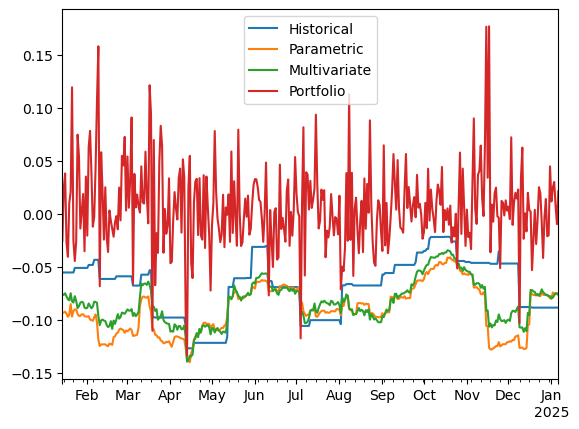

In [119]:
var_data.plot()

<Axes: >

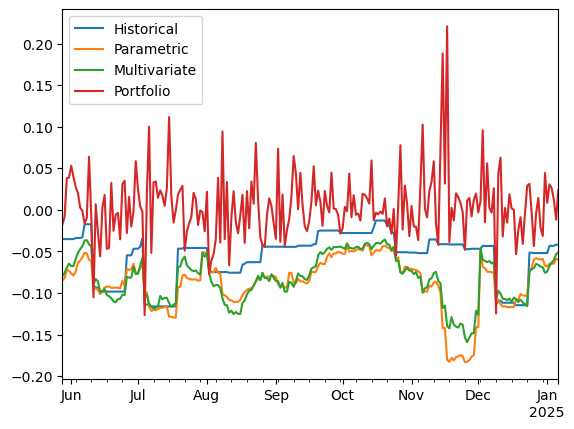

In [120]:
current_var_data.plot()

In [121]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.02507,0.011142,0.011142
Kupiec Stat,5.706263,16.452608,16.452608
P-value,0.016904,0.00005,0.00005


In [122]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.058036,0.017857,0.017857
Kupiec Stat,0.290194,6.403952,6.403952
P-value,0.590096,0.011387,0.011387


# Principal Component Analysis

## Historical PCA

In [125]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.77676713, 0.07159942, 0.05670895, 0.05154978, 0.04337472])

In [126]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.015425
ADAUSDT     0.015684
ALGOUSDT    0.017678
APTUSDT     0.016258
ARBUSDT     0.017162
              ...   
WBTCUSDT    0.009179
WLDUSDT     0.022093
XLMUSDT     0.012706
XRPUSDT     0.010854
XTZUSDT     0.016284
Name: PC1, Length: 62, dtype: float64

<Axes: >

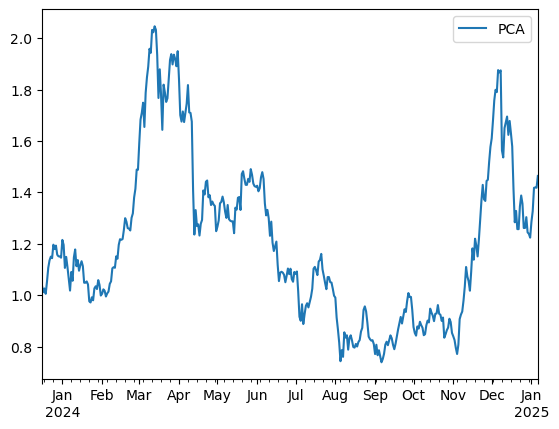

In [127]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<Axes: >

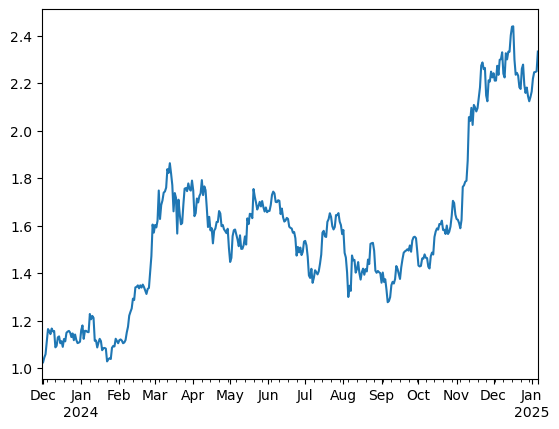

In [128]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [129]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
FLOWUSDT     0.422218
WBETHUSDT    0.433623
ETHUSDT      0.433700
ATOMUSDT     0.452861
               ...   
FLOKIUSDT    1.133176
WLDUSDT      1.141832
BONKUSDT     1.144909
PEPEUSDT     1.193526
OMUSDT       1.552065
Length: 63, dtype: float64

<Axes: >

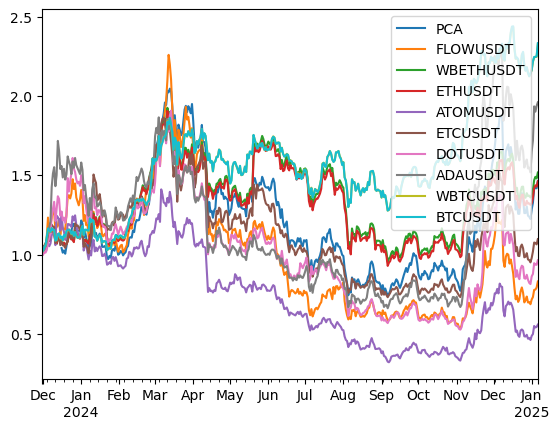

In [130]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<Axes: >

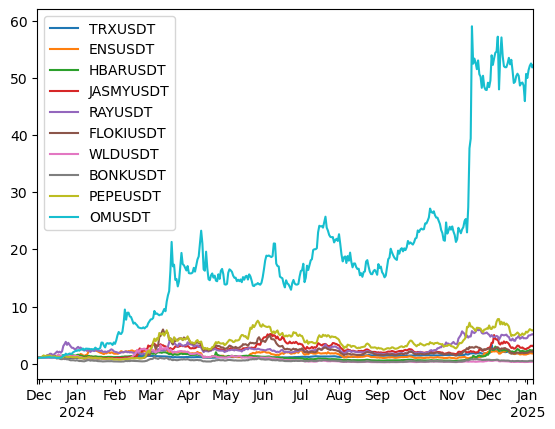

In [131]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [133]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.54515733, 0.14805697, 0.1303252 , 0.10166543, 0.07479507])

In [134]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.094868
BTCUSDT      0.061091
JASMYUSDT    0.170028
SOLUSDT      0.102607
ETHUSDT      0.083493
TRXUSDT      0.050853
BBUSDT       0.213544
BNBUSDT      0.067490
PEPEUSDT     0.156027
Name: PC1, dtype: float64

<Axes: >

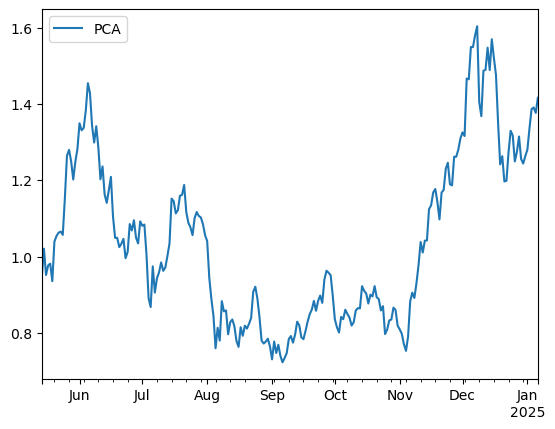

In [135]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<Axes: >

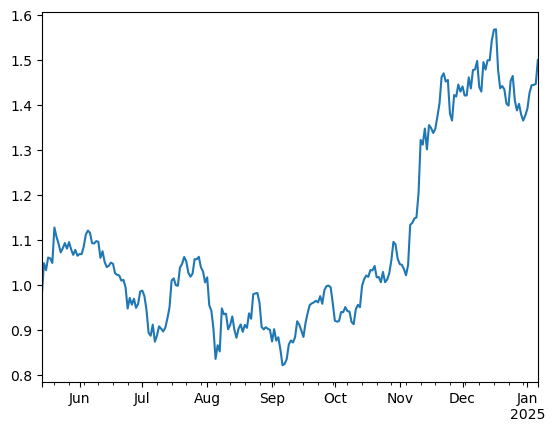

In [136]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [137]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
SOLUSDT      0.402319
ETHUSDT      0.416047
BNBUSDT      0.431615
BTCUSDT      0.449463
JASMYUSDT    0.661733
PEPEUSDT     0.724750
BBUSDT       0.748638
TRXUSDT      0.891887
OMUSDT       0.910591
dtype: float64

<Axes: >

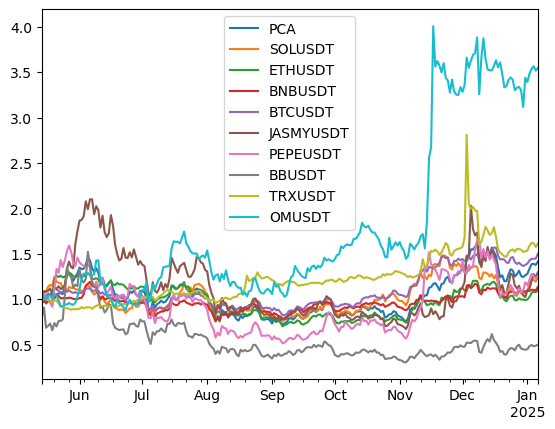

In [138]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [140]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.891332
BBUSDT       1.547158
JASMYUSDT    1.279091
SOLUSDT      1.151348
BTCUSDT      1.000000
ETHUSDT      0.959528
OMUSDT       0.874799
BNBUSDT      0.662367
TRXUSDT      0.286485
Name: BTCUSDT, dtype: float64

In [141]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

JASMYUSDT    2.034179
SOLUSDT      1.280730
PEPEUSDT     1.127297
BTCUSDT      1.000000
BBUSDT       0.956991
ETHUSDT      0.772431
OMUSDT       0.648820
TRXUSDT      0.455067
BNBUSDT      0.435268
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [143]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [144]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
ETHUSDT,0.484466
SOLUSDT,0.323188
JASMYUSDT,0.250053
TRXUSDT,0.239071
BBUSDT,0.060070
BNBUSDT,0.029217
PEPEUSDT,0.026875
OMUSDT,0.011241
BTCUSDT,-0.318035


### Regression to PCA

In [146]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-15:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.0481222935663819

In [147]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.270586
BNBUSDT      1.137783
ETHUSDT      1.009454
PCA          1.000000
SOLUSDT      0.816603
JASMYUSDT    0.428290
PEPEUSDT     0.387083
BBUSDT       0.361261
OMUSDT       0.234390
TRXUSDT      0.207017
dtype: float64

In [148]:
reg=ex_ante_perf.copy().dropna().iloc[-15:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

ETHUSDT      1.578059
TRXUSDT      1.301150
BTCUSDT      1.240772
BNBUSDT      1.121720
PCA          1.000000
SOLUSDT      0.959408
JASMYUSDT    0.596806
PEPEUSDT     0.537526
BBUSDT       0.505832
OMUSDT       0.272081
dtype: float64

### Correlation Matrix

<Axes: >

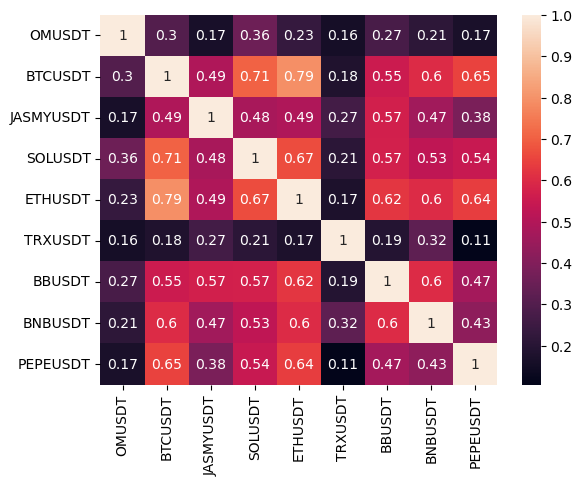

In [150]:
sns.heatmap(ex_ante_perf.corr(),annot=True)

<Axes: >

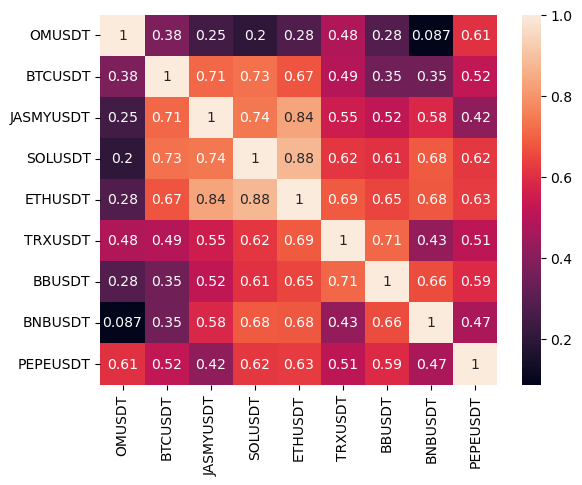

In [151]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

## Sliding window optimization

In [153]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.621968,0.000000,0.000000,0.000000,0.000000,0.000000,0.378032
2024-06-10,0.625939,0.000000,0.150852,0.000000,0.000000,0.223209,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2024-07-08,0.182528,0.000000,0.000000,0.000000,0.000000,0.817472,0.000000,0.000000,0.000000
2024-07-22,0.133242,0.414562,0.000000,0.112009,0.000000,0.340186,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926694,0.000000,0.073306,0.000000
2024-09-02,0.435138,0.000000,0.000000,0.000000,0.000000,0.564862,0.000000,0.000000,0.000000
2024-09-16,0.287440,0.000000,0.000000,0.000000,0.000000,0.000000,0.712560,0.000000,0.000000
2024-09-30,0.176666,0.000000,0.000000,0.000000,0.165949,0.527049,0.000000,0.000000,0.130336


In [154]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ARUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-05-31,0.000000,0.000000,0.0,0.0,0.0,0.110308,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
2024-06-30,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.938113,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
2024-07-30,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.333612,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.369961,0.0
2024-08-29,0.138060,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.861940,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
2024-09-28,0.052805,0.005501,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.022883,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
2024-10-28,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.622787,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
2024-11-27,0.000000,0.158594,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.115289,0.150160,0.0
2024-12-27,0.097549,0.010162,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.162944,0.0
2025-01-06,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.416932,0.0,0.0,0.042918,0.000000,0.0
